<a href="https://colab.research.google.com/github/wlg1/analogous_neuron_circuit_expms/blob/main/Copy_of_MNIST_1_vs_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

note: trying a small experiment where I was trying to compare how, if it does, a simple mlp trained only on 1s and 7s told them apart. I thought they'd be some circuit focusing on the diagonal slant or top line of 7. I tried editing 1s by making them look like 7s and vice versa but this actually didn't change its predictions (these were crude edits like adding a line so perhaps gradual handwritten ones would make more of a diff). Given that adversarial attacks are doing something hard to interpret, I wasn't really sure what the network was doing (I also tried it on the same network arch trained to have diff weights) so I stopped it quickly. Neel mentions in a vid olah also looked at mnist

---

https://www.kaggle.com/code/mishra1993/pytorch-multi-layer-perceptron-mnist/notebook

https://www.kaggle.com/code/pinocookie/pytorch-simple-mlp

In [ ]:
%%capture
import torch
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

## Dataset Download

In [ ]:
%%capture
!git clone https://github.com/wlg1/analogous_neuron_circuit_expms.git

! pip install kaggle
! mkdir ~/.kaggle
! cp /content/analogous_neuron_circuit_expms/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download digit-recognizer/data
! unzip data.zip

In [ ]:
class Dataset(object):
    """An abstract class representing a Dataset.
    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

# Get 1s and 7s only

In [ ]:
class TrainMNIST(Dataset):
    
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform

        ones = self.data.loc[self.data.iloc[:,0] == 1] 
        sevens = self.data.loc[self.data.iloc[:,0] == 7] 
        self.data = pd.concat([ones, sevens])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, we use ToTensor(), so we define the numpy array like (H, W, C)
        image = self.data.iloc[index, 1:].values.astype(np.uint8).reshape((28, 28, 1))
        label = self.data.iloc[index, 0]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label
        
class TestMNIST(Dataset):
    
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform

        ones = self.data.loc[self.data.iloc[:,0] == 1] 
        sevens = self.data.loc[self.data.iloc[:,0] == 7] 
        self.data = pd.concat([ones, sevens])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, we use ToTensor(), so we define the numpy array like (H, W, C)
        # image = self.data.iloc[index, 0:].values.astype(np.uint8).reshape((28, 28, 1))
        image = self.data.iloc[index, 1:].values.astype(np.uint8).reshape((28, 28, 1))
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image

In [ ]:
train_data = TrainMNIST('/content/sample_data/mnist_train_small.csv', transform=transforms.ToTensor())
test_data = TestMNIST('/content/sample_data/mnist_test.csv', transform=transforms.ToTensor())

In [ ]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
#transform = transforms.ToTensor()

# obtain training indices that will be used for validation
# num_train = len(train_data)
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers,)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

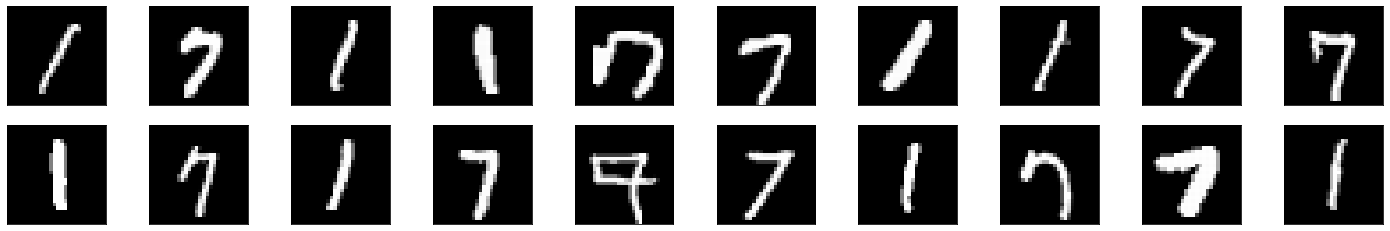

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    # ax.set_title(str(labels[idx].item()))

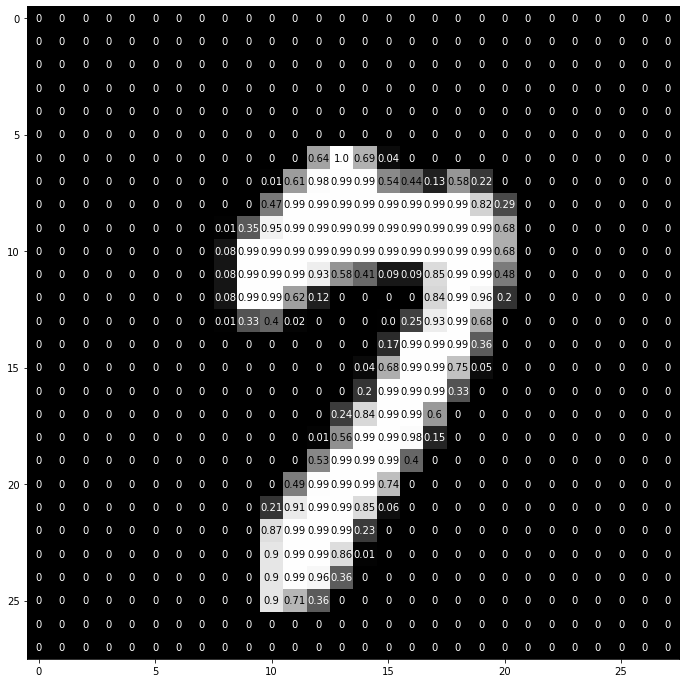

In [ ]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

# Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        hidden_1 = 512
        hidden_2 = 512
        self.fc1 = nn.Linear(28 * 28, hidden_1) # linear layer (784 -> hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 28 * 28) # flatten image input
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [ ]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
# number of epochs to train the model
n_epochs = 50

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training

    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

In [ ]:
model.load_state_dict(torch.load('one_v_seven.pt'))

<All keys matched successfully>

# Test Model

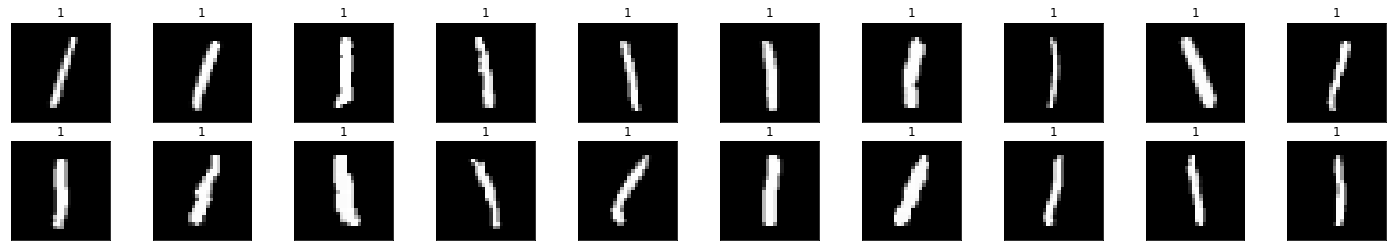

In [ ]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# obtain one batch of test images
dataiter = iter(test_loader)
images = next(dataiter)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{}".format(str(preds[idx].item())))

https://stackoverflow.com/questions/23151246/iterrows-pandas-get-next-rows-value

In [ ]:
%%capture
images = test_data.data.iloc[0, 1:].values.astype(np.uint8).reshape((28, 28, 1))

https://www.mindspore.cn/docs/migration_guide/en/r1.5/api_mapping/pytorch_diff/ToTensor.html

In [ ]:
image_transform = transforms.Compose([transforms.ToTensor()])
images = image_transform(images)

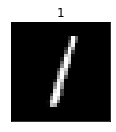

In [ ]:
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(1):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{}".format(str(preds[idx].item())))

In [ ]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, 
    num_workers=num_workers)
def predict(model, dataloader):
    prediction_list = []
    for i, batch in enumerate(dataloader):
        outputs = model(batch)
        _, predicted = torch.max(outputs.data, 1) 
        prediction_list.append(predicted.cpu())
    return prediction_list
predictions = predict(model,test_loader)
predictions = np.array(predictions)
# test_data = pd.read_csv("../input/test.csv")


# submission = pd.DataFrame(data={
#     "ImageId": test_data.index + 1,
#     "Label": predictions
# })
# submission.to_csv("submission.csv", index=None)
# submission.head(n=12).T

<ipython-input-18-3fafeb8b636f>:11: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  predictions = np.array(predictions)
<ipython-input-18-3fafeb8b636f>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predictions = np.array(predictions)


In [ ]:
predictions

array([tensor([1]), tensor([1]), tensor([1]), ..., tensor([7]),
       tensor([7]), tensor([7])], dtype=object)



---
# Get Activations


1000 images

In [ ]:
len(test_data.data.loc[test_data.data.iloc[:,0] == 1])

1135

In [ ]:
test_data.data.shape

(2162, 785)

In [ ]:
one_images = 0
for i in range(0, 1000):
    images = test_data.data.iloc[i, 1:].values.astype(np.uint8).reshape((28, 28, 1))
    image_transform = transforms.Compose([transforms.ToTensor()])
    images = image_transform(images)
    if i == 0:
        one_images = images
    else:
        one_images = torch.cat((one_images, images), 0)
one_images.shape

torch.Size([1000, 28, 28])

In [ ]:
# output = model(one_images)
# _, preds = torch.max(output, 1) # convert output probabilities to predicted class
# preds

tensor([1, 1, 1, 1])

In [ ]:
# get previous last layer name
named_layers = dict(model.named_modules())
layers = list(named_layers.keys())

# '' is first layer, the input, so disregard it
layers = [x for x in layers if x != '']  

In [ ]:
def get_activations(input, layer_name):
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    for name_to_check, layer in model.named_modules():
        if name_to_check == layer_name:
            break
    layer.register_forward_hook(get_activation(layer_name))
    
    output = model(input)

    return activation.copy()  #else will return the same actvs of model

In [ ]:
ones_activation_nameVal = {}
for layer_name in layers:
    ones_activation_nameVal[layer_name] = get_activations(one_images, layer_name)[layer_name]

In [ ]:
ones_activation_nameVal['fc1'].shape

torch.Size([1000, 512])

In [ ]:
seven_images = 0
for i in range(1136, 2136):
    images = test_data.data.iloc[i, 1:].values.astype(np.uint8).reshape((28, 28, 1))
    image_transform = transforms.Compose([transforms.ToTensor()])
    images = image_transform(images)
    if i == 1136:
        seven_images = images
    else:
        seven_images = torch.cat((seven_images, images), 0)
seven_images.shape

sevens_activation_nameVal = {}
for layer_name in layers:
    sevens_activation_nameVal[layer_name] = get_activations(seven_images, layer_name)[layer_name]

In [ ]:
output = model(seven_images)
_, preds = torch.max(output, 1) # convert output probabilities to predicted class
preds.tolist().count(7)

985

# Attempt 1: Average each neuron

For every neuron, compare within 1s vs within 7s to see which neurons have most drastic differences


In [ ]:
layer_name = 'fc1'
print(ones_activation_nameVal[layer_name][0][511])
print(ones_activation_nameVal[layer_name][1][511])
ones_activation_nameVal[layer_name][0][511] + ones_activation_nameVal[layer_name][1][511]

tensor(-0.0047)
tensor(-0.0952)


tensor(-0.0999)

Get the average of all the activations in a layer for all images in the test set of each class.

In [ ]:
layer_name = 'fc1'
for img_ind in range(one_images.shape[0]):
    if img_ind == 0:
        sum_tensor = ones_activation_nameVal[layer_name][img_ind]
    else:
        sum_tensor = sum_tensor + ones_activation_nameVal[layer_name][img_ind]
avg_tensor_ones = sum_tensor / one_images.shape[0]

In [ ]:
layer_name = 'fc1'
for img_ind in range(seven_images.shape[0]):
    if img_ind == 0:
        sum_tensor = sevens_activation_nameVal[layer_name][img_ind]
    else:
        sum_tensor = sum_tensor + sevens_activation_nameVal[layer_name][img_ind]
avg_tensor_sevens = sum_tensor / seven_images.shape[0]

In [ ]:
diffs = avg_tensor_ones - avg_tensor_sevens

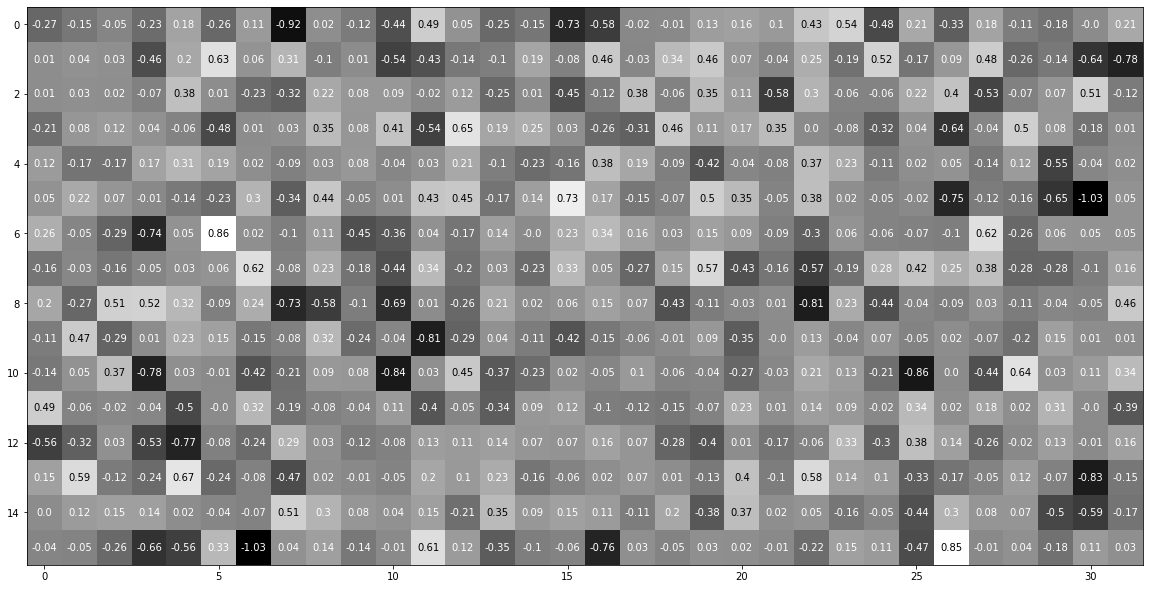

In [ ]:
img = diffs.numpy().reshape((16, 32))  # there are 512 activations; reshape into 2D

fig = plt.figure(figsize = (20,20)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

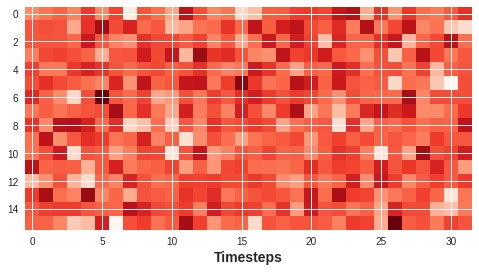

In [ ]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')
plt.imshow(img, cmap='Reds')
plt.xlabel('Timesteps', weight='bold', fontsize=14)
plt.show()

<AxesSubplot:>

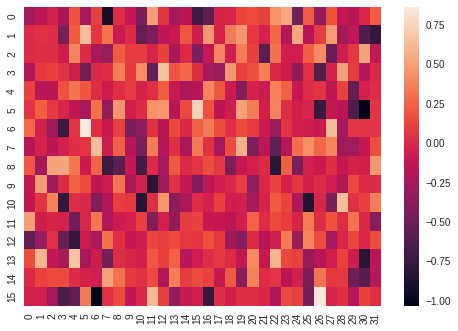

In [ ]:
import seaborn
fig, ax = plt.subplots()
seaborn.heatmap(img)

(array([  5.,  13.,  21.,  38.,  94., 187.,  83.,  48.,  20.,   3.]),
 array([-1.0335639 , -0.8441229 , -0.65468186, -0.4652409 , -0.2757999 ,
        -0.0863589 ,  0.10308208,  0.2925231 ,  0.48196405,  0.6714051 ,
         0.86084604], dtype=float32),
 <BarContainer object of 10 artists>)

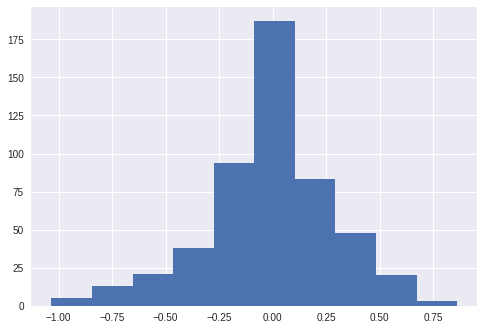

In [ ]:
plt.hist(diffs, 10)

Now knockout the ones that are the most diff, and compare to knocking out all other ones.

Knockout neurons above a certain threshold.

# Compare slight mods of input

---
It's much easier to modify input first and check weights, than to modify weights and see what happens.

This is because you know semantically what the input values are, whereas you have to randomly search what the weights are.

Slightly modify the input and see what happens to each activation. Try different modification levels


## Compare original vs modified by adding line of ones to an ‘1’ image.

Add line of ones manually looking at pixel map. Try on first image of ones dataset. Compare model prediction of original vs modified.

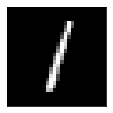

In [ ]:
# input variable
img_example = torch.clone(one_images[0])  # torch slices are pass by ref when doing =

def show_img_small(img):
    img_disp = img.numpy() # prep images for display
    fig = plt.figure(figsize=(25, 4))
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(img_disp), cmap='gray')

show_img_small(img_example)

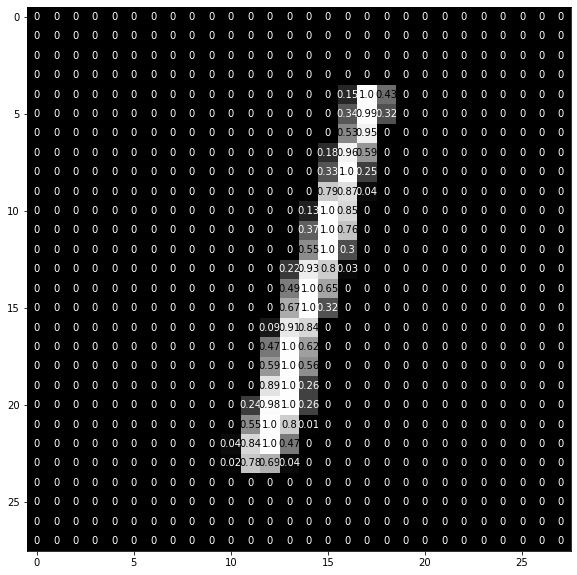

In [ ]:
def show_pixel_map(img):
    img = img.numpy() # prep images for display
    fig = plt.figure(figsize = (10,10)) 
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

show_pixel_map(img_example)

In [ ]:
img_example_2 = torch.clone(img_example)
modifier = torch.ones(img_example[5].size()[0])
# img_example_2[5] = img_example_2[5] + modifier
img_example_2[5] = modifier

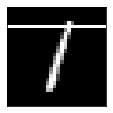

In [ ]:
show_img_small(img_example_2)

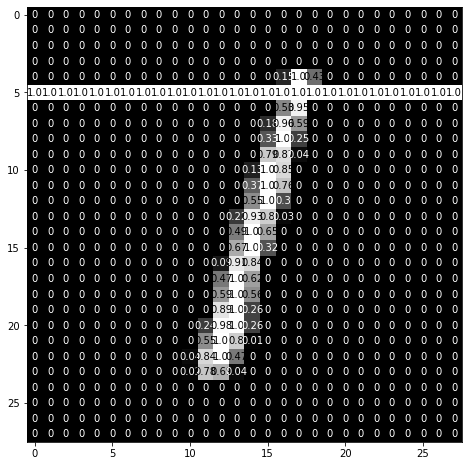

In [ ]:
show_pixel_map(img_example_2)

In [ ]:
output = model(img_example_2)
_, preds = torch.max(output, 1)
preds[0].item()

1

In [ ]:
output = model(seven_images[0])
_, preds = torch.max(output, 1)
preds[0].item()

7

## Compare original vs modified by adding line of ones (right tail not too big) to an ‘1’ image.

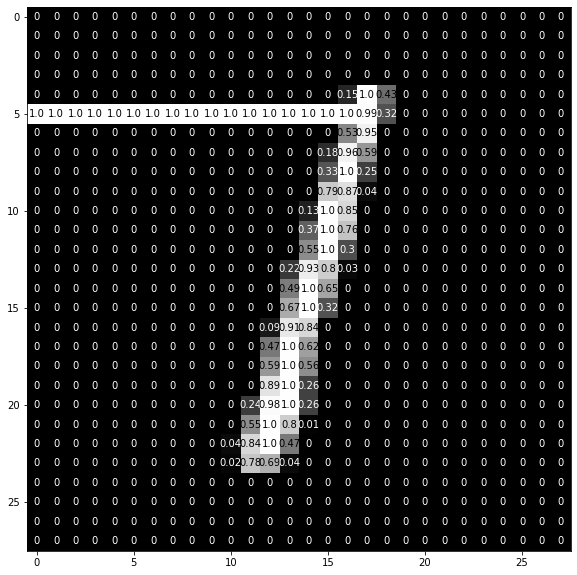

In [ ]:
img_example_2 = torch.clone(img_example)

range_to_addOnes = (img_example[5].size()[0]) // 2
range_to_addOnes += 3

for i in range(range_to_addOnes):
    img_example_2[5][i] = 1

show_pixel_map(img_example_2)

In [ ]:
output = model(img_example_2)
_, preds = torch.max(output, 1)
preds[0].item()

1

## Compare original vs modified by adding line of ones (right tail not too big and add more modified lines) to an ‘1’ image.

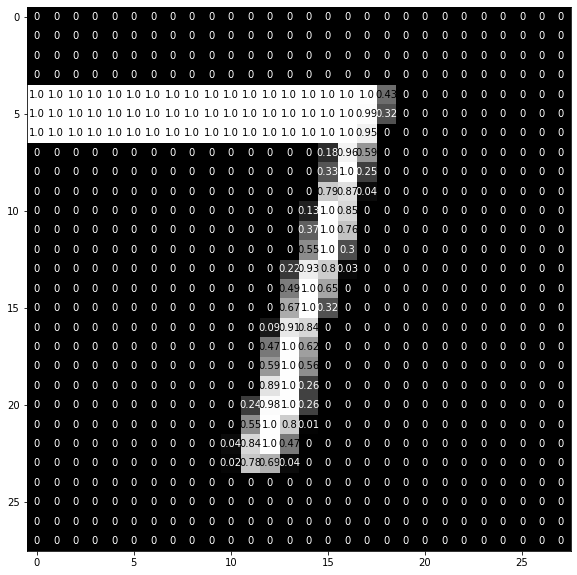

In [ ]:
img_example_2 = torch.clone(img_example)

range_to_addOnes = (img_example[5].size()[0]) // 2
range_to_addOnes += 3

for col in range(range_to_addOnes):
    for row in range(4,7):
        img_example_2[row][col] = 1

show_pixel_map(img_example_2)

## Look at the probabilities of each class, not just the final prediction

Just adding top line:

In [ ]:
img_example_2 = torch.clone(img_example)
modifier = torch.ones(img_example[5].size()[0])
img_example_2[5] = modifier
output = model(img_example_2)
output

tensor([[-1.2364,  9.0585, -1.3754, -1.3820, -1.6784, -1.5348, -1.2074,  1.3064,
         -1.2620, -1.4275]], grad_fn=<AddmmBackward0>)

For just adding top line (right tail gone):

In [ ]:
img_example_2 = torch.clone(img_example)

range_to_addOnes = (img_example[5].size()[0]) // 2
range_to_addOnes += 3

for i in range(range_to_addOnes):
    img_example_2[5][i] = 1

output = model(img_example_2)
output

tensor([[-1.3842,  8.7628, -1.2970, -1.5689, -1.2009, -1.4786, -1.1422,  0.9336,
         -1.2672, -1.2331]], grad_fn=<AddmmBackward0>)

For adding top line (right tail gone) and add more modified lines:

In [ ]:
img_example_2 = torch.clone(img_example)

range_to_addOnes = (img_example[5].size()[0]) // 2
range_to_addOnes += 3

for col in range(range_to_addOnes):
    for row in range(4,7):
        img_example_2[row][col] = 1

output = model(img_example_2)
output

tensor([[-1.4518,  8.9397, -1.4346, -1.5318, -1.5896, -1.4712, -1.5184,  1.7714,
         -1.1901, -1.4597]], grad_fn=<AddmmBackward0>)

SLIGHT ERROR: This model has 10 outputs, but we just wanted 2. However, this doesn't seem to affect the output probability much because the other classes are usually negative, much lower than classes 1 and 7.

RESULT: 

For just adding top line (full), the probabilities are 9.0585 (class 1) vs 1.3064 (class 7)

For just adding top line (right tail gone), the probabilities are 8.7628 (class 1) vs 0.9336 (class 7)

For adding top line (right tail gone) and add more modified lines, the probabilities are 10.4093 (class 1) vs 1.7214 (class 7)

ANALYSIS:

Why isn’t there a pattern to how the probabilities change as the image is modified to look “more like 7”?

## Make an entirely new ‘7’ that’s just a horizontal line and a vertical. 

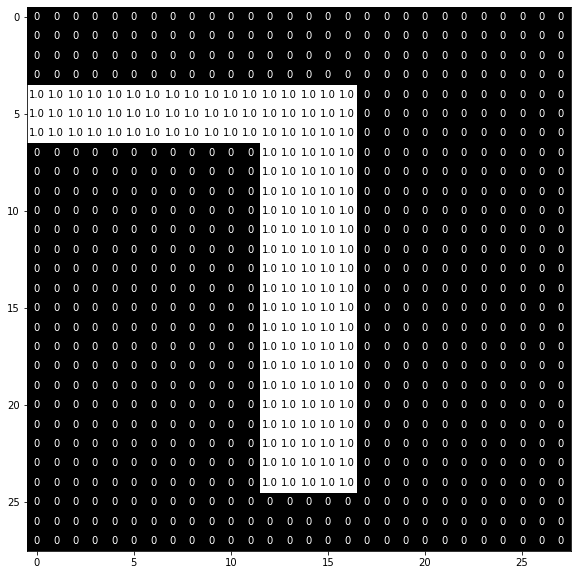

In [ ]:
img_example_2 = torch.zeros(([28, 28]))

range_to_addOnes = (img_example[5].size()[0]) // 2
range_to_addOnes += 3

for col in range(range_to_addOnes):
    for row in range(4,7):
        img_example_2[row][col] = 1

for col in range(12,17):
    for row in range(6,25):
        img_example_2[row][col] = 1

# show_img_small
show_pixel_map(img_example_2)

In [ ]:
output = model(img_example_2)
output

tensor([[-2.3466, 12.5388, -2.7577, -2.8460, -2.6495, -2.6185, -2.1980,  7.4132,
         -2.0027, -2.3694]], grad_fn=<AddmmBackward0>)

In [ ]:
img_example_2 = torch.zeros(([28, 28]))

range_to_addOnes = (img_example[5].size()[0]) // 2
range_to_addOnes += 3

for col in range(range_to_addOnes):
    for row in range(1,7):
        img_example_2[row][col] = 1

for col in range(12,17):
    for row in range(6,25):
        img_example_2[row][col] = 1

# show_img_small
show_pixel_map(img_example_2)

In [ ]:
output = model(img_example_2)
output

tensor([[-2.4962, 13.0826, -2.2703, -2.9389, -2.2922, -2.8575, -2.5294,  6.4184,
         -2.3506, -2.6344]], grad_fn=<AddmmBackward0>)

## Take existing ‘7’ image and remove the top line to turn into ‘1’ and see what outputs are

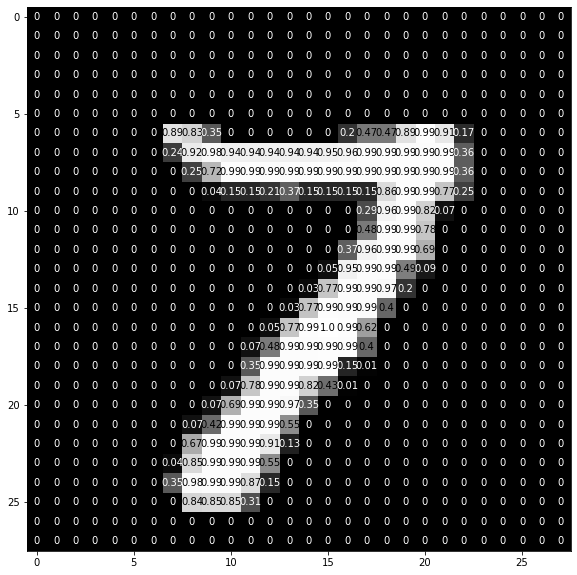

In [ ]:
# input variable
img_example = torch.clone(seven_images[1])  # torch slices are pass by ref when doing =
show_pixel_map(img_example)

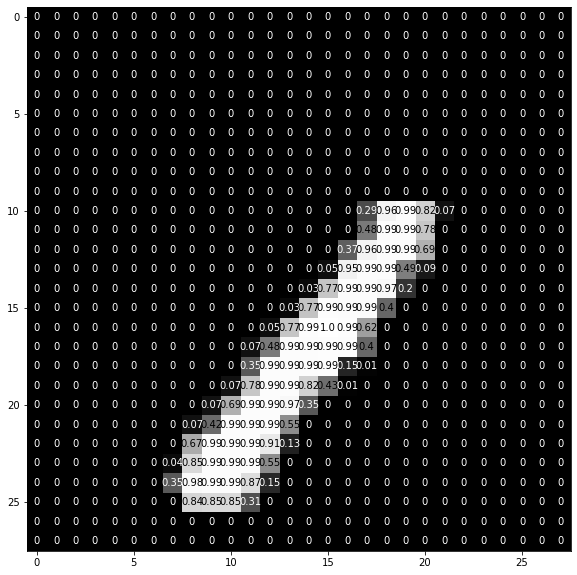

In [ ]:
img_example_2 = torch.clone(img_example)

for row in range(6, 10):
    img_example_2[row] = 0
show_pixel_map(img_example_2)

In [ ]:
output = model(img_example_2)
output

tensor([[-1.7598,  3.8339, -1.5209, -1.3557, -1.8499, -1.3327, -1.4784,  8.3270,
         -1.3954, -1.5258]], grad_fn=<AddmmBackward0>)

## Turn all pixels in an image of ‘7’ into 0

Then look at output probabilities

This is a sanity check to make sure the model somehow isn’t “fixed” on making a certain image file be a class despite modifications to it, perhaps b/c it’s somehow referencing the original data it came from.

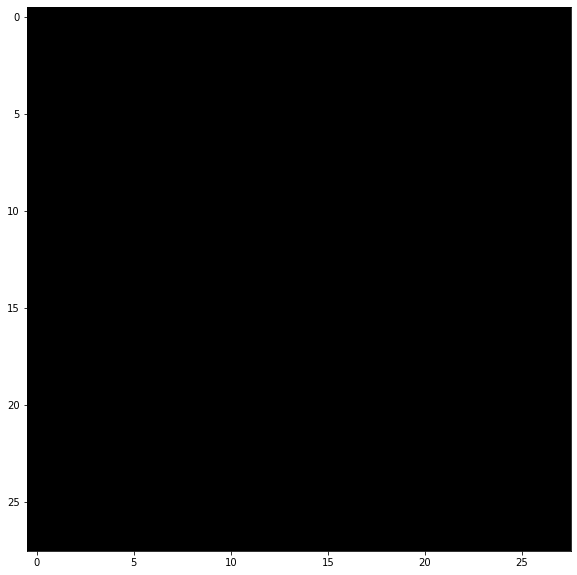

In [ ]:
img_example_2 = torch.clone(img_example)

for row in range(0, 28):
    img_example_2[row] = 0
show_pixel_map(img_example_2)

In [ ]:
output = model(img_example_2)
output

tensor([[-0.2138,  0.9715, -0.2150, -0.1903, -0.2204, -0.1819, -0.1769,  0.6963,
         -0.1874, -0.2031]], grad_fn=<AddmmBackward0>)

## Corrupt the ‘7’ image until it no longer is able to distinguish it as a ‘7’.

Use binary search: Start by removing rows 0 to 14

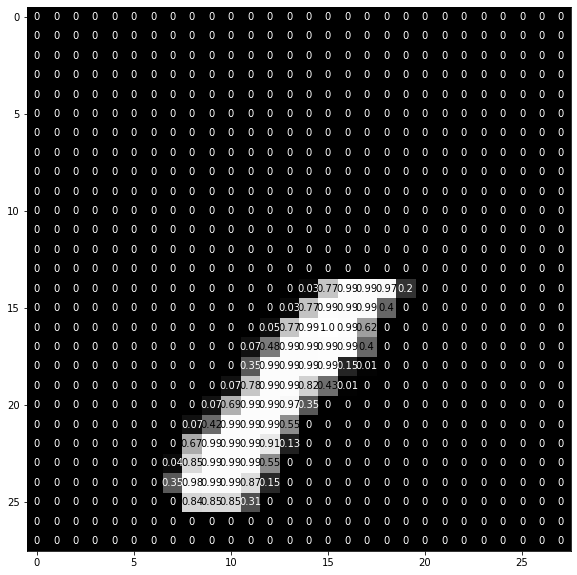

In [ ]:
img_example_2 = torch.clone(img_example)

for row in range(0, 14):
    img_example_2[row] = 0
show_pixel_map(img_example_2)

In [ ]:
output = model(img_example_2)
output

tensor([[-1.3851,  4.8885, -1.1722, -1.2756, -1.4588, -1.3128, -1.1553,  4.8214,
         -1.0095, -1.2770]], grad_fn=<AddmmBackward0>)

Next, Try removing rows 7 to 14.

tensor([[-1.4180,  5.1678, -1.2487, -1.3182, -1.4813, -1.2811, -1.0367,  5.0726,
         -1.2162, -1.2093]], grad_fn=<AddmmBackward0>)

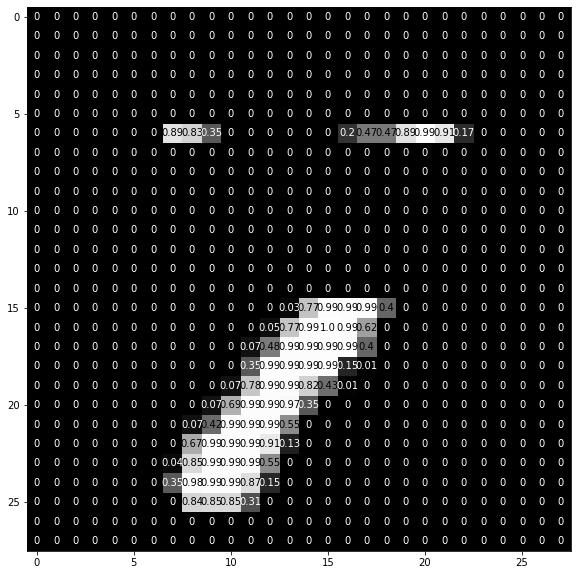

In [ ]:
img_example_2 = torch.clone(img_example)
for row in range(7, 15):
    img_example_2[row] = 0
show_pixel_map(img_example_2)
model(img_example_2)

Again, it's ambiguous. We know 6 to 10 didn't work. Now try rows 6 to 12

tensor([[-1.3261,  4.8194, -1.4428, -1.2207, -1.3510, -1.2771, -1.1686,  6.0789,
         -1.1828, -1.1427]], grad_fn=<AddmmBackward0>)

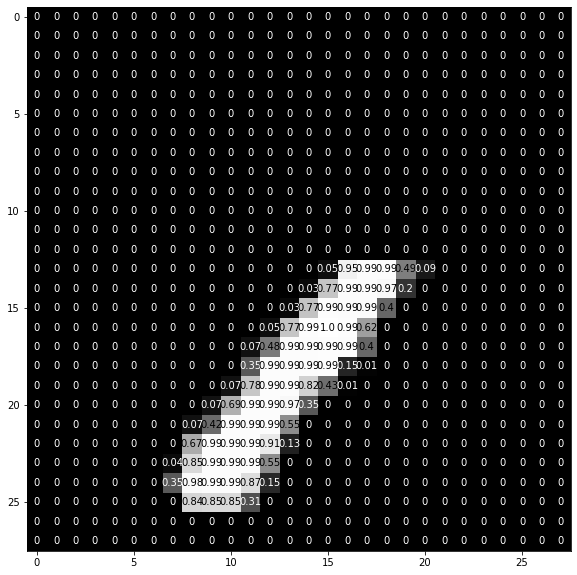

In [ ]:
img_example_2 = torch.clone(img_example)
for row in range(6, 13):
    img_example_2[row] = 0
show_pixel_map(img_example_2)
model(img_example_2)

Here, it's still at 7, but more ambiguous. Try 6 to 14 just to compare it to 0 to 14 (should be the same.

In [ ]:
img_example_2 = torch.clone(img_example)
for row in range(6, 14):
    img_example_2[row] = 0
model(img_example_2)

tensor([[-1.4890,  4.9897, -1.2951, -1.3462, -1.4525, -1.2008, -1.2146,  5.4289,
         -1.1281, -1.3526]], grad_fn=<AddmmBackward0>)

In [ ]:
img_example_2 = torch.clone(img_example)
for row in range(0, 14):
    img_example_2[row] = 0
model(img_example_2)

tensor([[-1.2546,  4.8747, -1.2024, -1.3079, -1.3818, -1.0705, -0.9694,  4.5051,
         -1.1428, -1.0857]], grad_fn=<AddmmBackward0>)

RESULT: If you run them multiple times, you get different results. Sometimes 1 slightly beats 7, sometimes 7 beats 1. So this is ‘very ambiguous’.

TEST: Since we know the variation is bigger when removing around rows 10-14, try running it again when removing 6 to 12

In [ ]:
img_example_2 = torch.clone(img_example)
for row in range(6, 13):
    img_example_2[row] = 0
# show_pixel_map(img_example_2)
model(img_example_2)

tensor([[-1.4900,  4.6890, -1.2145, -1.2051, -1.2420, -1.1437, -1.1853,  5.5454,
         -1.1604, -1.2934]], grad_fn=<AddmmBackward0>)

RESULT: If we run it multiple times, it’s STILL saying it’s 7 all the time, though not by much. 

ANALYSIS: This means row 13 appears to be “crucial”. The model may be detecting that this is the “connecting part” b/w the top line and the bottom line.

# old

In [ ]:
input_2 = x_train[0] + torch.tensor([0.1,0])
input_2

tensor([ 0.6815, -8.9559])

In [ ]:
for layer_name in layers:
    print(get_activations(input_2, layer_name))

{'fc1': tensor([7.9596, 8.3923])}
{'relu': tensor([7.9596, 8.3923])}
{'fc2': tensor([3.2521])}
{'sigmoid': tensor([0.9627])}




---



In [ ]:
input_3 = x_train[0] + torch.tensor([1,0])
for layer_name in layers:
    print(get_activations(input_3, layer_name))

{'fc1': tensor([8.1595, 8.5033])}
{'relu': tensor([8.1595, 8.5033])}
{'fc2': tensor([3.0181])}
{'sigmoid': tensor([0.9534])}


In [ ]:
model.fc1.weight.data

tensor([[ 0.2221, -0.5793],
        [ 0.1234, -1.1833]])

In [ ]:
torch.matmul(model.fc1.weight.data, input_2 ) + model.fc1.bias

tensor([7.9596, 8.3923], grad_fn=<AddBackward0>)

Find a local motif. This is a local circuit?

## Compare mods as interpolate from 1 number to another

Eg) Transform input 0 to 8



---

# Modify weights



In [ ]:
for ly in model.named_modules():
    if ly[0] != '' and ly[0] != 'dropout':
        print(ly[1].weight.data)

In [ ]:
layers = ['fc1', 'fc2', 'fc3']
for ly in model.named_modules():
    if ly[0] == 'fc1':
        print(ly[1].weight.data.shape)

torch.Size([512, 784])


Neurons are rows in weights (for go into neuron) and cols in next layer weight matrix (for go out of neuron). To knockout a neuron, set all weights in the incoming weight matrix to 0, and also to outgoing weight matrix.

Before modifying neurons, let's modify a single weight.

In [ ]:
model_copy = copy.deepcopy(model)

In [ ]:
for ly in model_copy.named_modules():
    if ly[0] == 'fc1':
        layer_0_to_1_weights = ly[1].weight.data

Set entire first row to 0. Every single pixel (out of 784) that goes into first neuron (out of 512) is 'blocked'. Thus the outcoming activations will also be blocked if bias is set to 0.

In [ ]:
layer_0_to_1_weights[0] = 0  # pass by ref

In [ ]:
for ly in model_copy.named_modules():
    if ly[0] == 'fc1':
        print(layer_0_to_1_weights)  #print(ly[1].weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0049,  0.0246,  0.0163,  ..., -0.0185, -0.0082,  0.0146],
        [-0.0130, -0.0197,  0.0202,  ..., -0.0347,  0.0135, -0.0022],
        ...,
        [-0.0291,  0.0301,  0.0201,  ..., -0.0129,  0.0162,  0.0297],
        [-0.0276, -0.0149, -0.0290,  ...,  0.0331,  0.0246, -0.0305],
        [-0.0231, -0.0138,  0.0048,  ...,  0.0214, -0.0013,  0.0294]])


In [ ]:
out = model_copy(train_data.__getitem__(5)[0])
out

tensor([[15.4554, -7.5636,  5.6183,  1.0914, -9.2264,  0.3566, -1.5256,  0.6211,
         -6.5946, -0.4437]], grad_fn=<AddmmBackward0>)

ISSUE: Dropout is random, so get diff output values each run

In [ ]:
torch.argmax(out).item()

0

## Set weights above threshold to 0 and compare to hist of random weights set to 0

Set weights where diff of ones and sevens above certain threshold to 0. Compare with avg of same # of weights chosen randomly set to 0, to see if any sigf. Get histogram of random weights set to 0.

In [ ]:
num_weights_knockedout = 0
model_copy = copy.deepcopy(model)
for ly in model_copy.named_modules():
    if ly[0] == 'fc1':
        layer_0_to_1_weights = ly[1].weight.data
        break
for weight in range(512):
    if abs(diffs[weight]) > 0.25:
        layer_0_to_1_weights[weight] = 0
        num_weights_knockedout += 1
print(num_weights_knockedout)

173


In [ ]:
output = model(seven_images)
_, preds = torch.max(output, 1) # convert output probabilities to predicted class
preds.tolist().count(7) / len(preds)

0.991

In [ ]:
output_afterCorrupt = model_copy(seven_images)
_, preds = torch.max(output_afterCorrupt, 1) # convert output probabilities to predicted class
preds.tolist().count(7) / len(preds)

0.228

Try with 0.5

In [ ]:
num_weights_knockedout = 0
model_copy_2 = copy.deepcopy(model)
for ly in model_copy_2.named_modules():
    if ly[0] == 'fc1':
        layer_0_to_1_weights = ly[1].weight.data
        break
for weight in range(512):
    if abs(diffs[weight]) > 0.5:
        layer_0_to_1_weights[weight] = 0
        num_weights_knockedout += 1
print(num_weights_knockedout)

output_afterCorrupt_2 = model_copy_2(seven_images)
_, preds = torch.max(output_afterCorrupt_2, 1) # convert output probabilities to predicted class
preds.tolist().count(7) / len(preds)

61


0.92

Try with 0.1

In [ ]:
num_weights_knockedout = 0
model_copy_2 = copy.deepcopy(model)
for ly in model_copy_2.named_modules():
    if ly[0] == 'fc1':
        layer_0_to_1_weights = ly[1].weight.data
        break
for weight in range(512):
    if abs(diffs[weight]) > 0.1:
        layer_0_to_1_weights[weight] = 0
        num_weights_knockedout += 1
print(num_weights_knockedout)

output_afterCorrupt_2 = model_copy_2(seven_images)
_, preds = torch.max(output_afterCorrupt_2, 1) # convert output probabilities to predicted class
preds.tolist().count(7) / len(preds)

323


0.0

Try at various intervals and plot it

In [ ]:
thrs_acc = {}
thrs_acc_ones = {}
for thrs in range(1, 10):
    thrs /= 10
    num_weights_knockedout = 0
    model_copy_2 = copy.deepcopy(model)
    for ly in model_copy_2.named_modules():
        if ly[0] == 'fc1':
            layer_0_to_1_weights = ly[1].weight.data
            break
    for weight in range(512):
        if abs(diffs[weight]) > thrs:
            layer_0_to_1_weights[weight] = 0
            num_weights_knockedout += 1

    output_afterCorrupt_2 = model_copy_2(seven_images)
    _, preds = torch.max(output_afterCorrupt_2, 1) # convert output probabilities to predicted class
    acc = preds.tolist().count(7) / len(preds)
    thrs_acc[thrs] = acc
    print(thrs, num_weights_knockedout, acc)

    output_afterCorrupt_2 = model_copy_2(one_images)
    _, preds = torch.max(output_afterCorrupt_2, 1) # convert output probabilities to predicted class
    acc = preds.tolist().count(1) / len(preds)
    thrs_acc_ones[thrs] = acc
    print(thrs, num_weights_knockedout, acc)

0.1 323 0.0
0.1 323 1.0
0.2 205 0.044
0.2 205 1.0
0.3 142 0.581
0.3 142 1.0
0.4 94 0.874
0.4 94 1.0
0.5 61 0.92
0.5 61 1.0
0.6 31 0.955
0.6 31 1.0
0.7 21 0.969
0.7 21 1.0
0.8 14 0.976
0.8 14 1.0
0.9 5 0.988
0.9 5 0.999


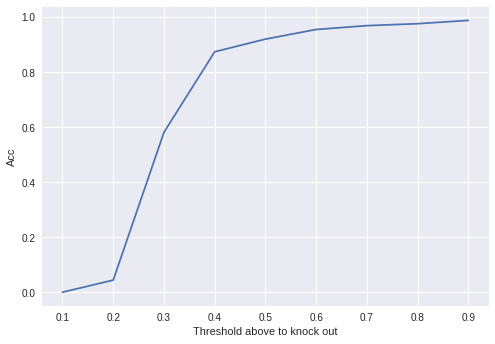

In [ ]:
import matplotlib.pyplot as plt
plt.ylabel('Acc')
plt.xlabel('Threshold above to knock out')
plt.plot(thrs_acc.keys(), thrs_acc.values())

(array([  3.,  15.,  23.,  38.,  93., 189.,  89.,  44.,  16.,   2.]),
 array([-1.1128615 , -0.90891486, -0.7049682 , -0.50102156, -0.2970749 ,
        -0.09312826,  0.11081839,  0.31476504,  0.5187117 ,  0.72265834,
         0.926605  ], dtype=float32),
 <BarContainer object of 10 artists>)

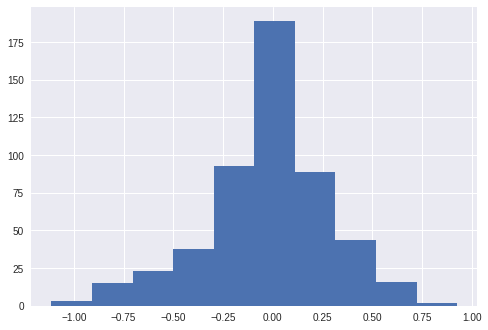

In [ ]:
plt.hist(diffs, 10)

In [ ]:
sum(abs(i) < 0.2 for i in diffs.tolist() ) / len(diffs)

0.599609375

Around 60% of neurons have an activation difference of less than 0.2. Notice that destroying neurons which have a difference above 0.4 doesn't have as much effect as destroying those above 0.3, and even more so for 0.2.

From this, it seems like the 'highest activated neurons' are not so important as the number of neurons firing above some level. Those neurons b/w 0.3 and 0.4 are very impt.

Is this because of the % of neurons destroyed, or specifically those neurons above a certain threshold?



---

## Set randoms to 0

In [ ]:
import random
random_destroy_accs = []

for i in range(10):
    weights_to_destroy = random.sample(range(0, 512), 142)

    model_copy = copy.deepcopy(model)
    for ly in model_copy.named_modules():
        if ly[0] == 'fc1':
            layer_0_to_1_weights = ly[1].weight.data
            break
    for weight in weights_to_destroy:
        layer_0_to_1_weights[weight] = 0

    output_afterCorrupt = model_copy(seven_images)
    _, preds = torch.max(output_afterCorrupt, 1) # convert output probabilities to predicted class
    acc = preds.tolist().count(7) / len(preds)
    random_destroy_accs.append(acc)
print(random_destroy_accs)

[0.989, 0.99, 0.986, 0.989, 0.992, 0.992, 0.986, 0.991, 0.99, 0.991]


One peculiar thing is that while 7 changes, 1 doesn't. It seems these highly firing neurons above 0.1 are turning 1s into 7s, but not the other way around. 

HYPOTHESIS: The "1" is the default; the "7" is if there's something special, like a line above 1.

## Set only neurons b/w 0.3 and 0.4 to 0

Is it all the neurons above a threshold, or just these particular neurons?

In [ ]:
thrs = 0.3
num_weights_knockedout = 0
model_copy_2 = copy.deepcopy(model)
for ly in model_copy_2.named_modules():
    if ly[0] == 'fc1':
        layer_0_to_1_weights = ly[1].weight.data
        break
for weight in range(512):
    if abs(diffs[weight]) > thrs and abs(diffs[weight]) < thrs + 0.1:
        layer_0_to_1_weights[weight] = 0
        num_weights_knockedout += 1

output_afterCorrupt_2 = model_copy_2(seven_images)
_, preds = torch.max(output_afterCorrupt_2, 1) # convert output probabilities to predicted class
acc = preds.tolist().count(7) / len(preds)
thrs_acc[thrs] = acc
print(thrs, num_weights_knockedout, acc)

0.3 48 0.991


It appears that it's all of them working together. 

So we have narrowed down the list to 142 impt neurons. Which of these, in a subset, work together? There's too many combos to try. 

Instead of looking for the ENTIRE classification, try 'JUST THE NEXT STEP'. That is, does knocking out a certain combo destroy ONE neuron in the next layer?

Which are the highest activating neurons in penultimate layer that are impt for final class neuron of '7'? See which neurons affect those. This is the subproblem. Then, add another neuron to these.

One neuron is connected to another in terms of use. The abstract class of 'dog neurons' will be used for both 'dog ears' and 'dog tail'?

# Find weights connected to "upper region"

Which are the neurons that detect the "upper region" above the 1? This is topological given how varied the 1 sizes are. The weights that highly activate on a certain position wouldn't make sense, if it's topological instead of being in an exact position.



In one or a few images: Take all weights going into input of "top line" (find this by manually looking at visualizations) and knock them out. See how classification changes from 7 to 1. 

Given that columns of matrix are "inputs", each column is an input pixel. Knock out entire columns by setting them to 0.



---



---



## Set neurons in ordered list to 0

In [ ]:
model_copy = copy.deepcopy(model)
for ly in model_copy.named_modules():
    if ly[0] == 'fc1':
        layer_0_to_1_weights = ly[1].weight.data
        break
layer_0_to_1_weights[layer_0_to_1_weights !=0] = 0
for ly in model_copy.named_modules():
    if ly[0] == 'fc1':
        print(layer_0_to_1_weights)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [ ]:
out = model_copy(train_data.__getitem__(5)[0])
out

tensor([[-0.4796,  0.2182, -0.3352, -0.9927,  0.5191,  1.8772,  0.0308,  0.3985,
         -1.1687, -0.1355]], grad_fn=<AddmmBackward0>)

In [ ]:
if torch.argmax(out).item() != 0:
    print(torch.argmax(out).item())

5


Changing a single neuron row still allows it to recognize 0. Destroying the 1st layer obviously makes it fail; that's an extreme case.

So for mid-cases, let's destroy combos of neurons. Maybe binary search? Dynamic programming?

In [ ]:
weights_to_destroy = list(range(256))

model_copy = copy.deepcopy(model)
for ly in model_copy.named_modules():
    if ly[0] == 'fc1':
        layer_0_to_1_weights = ly[1].weight.data
        break
for weight in weights_to_destroy:
    layer_0_to_1_weights[weight] = 0
out = model_copy(train_data.__getitem__(5)[0])
if torch.argmax(out).item() != 0:
    print(torch.argmax(out).item())

In [ ]:
out

tensor([[ 7.3655e+00, -4.4257e+00,  2.4717e+00,  1.3028e+00, -6.4183e+00,
          2.0776e+00, -9.2014e-01,  3.2406e-03, -2.5161e+00, -2.2169e-01]],
       grad_fn=<AddmmBackward0>)

In [ ]:
weights_to_destroy = list(range(400))

model_copy = copy.deepcopy(model)
for ly in model_copy.named_modules():
    if ly[0] == 'fc1':
        layer_0_to_1_weights = ly[1].weight.data
        break
for weight in weights_to_destroy:
    layer_0_to_1_weights[weight] = 0
out = model_copy(train_data.__getitem__(5)[0])
if torch.argmax(out).item() != 0:
    print(torch.argmax(out).item())

In [ ]:
out

tensor([[ 3.3306, -1.7898,  1.1541,  0.2265, -2.8633,  2.9666,  0.4339, -1.1646,
         -1.4329, -1.0655]], grad_fn=<AddmmBackward0>)

In [ ]:
weights_to_destroy = list(range(500))

model_copy = copy.deepcopy(model)
for ly in model_copy.named_modules():
    if ly[0] == 'fc1':
        layer_0_to_1_weights = ly[1].weight.data
        break
for weight in weights_to_destroy:
    layer_0_to_1_weights[weight] = 0
out = model_copy(train_data.__getitem__(5)[0])
if torch.argmax(out).item() != 0:
    print(torch.argmax(out).item())

5


So even at 400 first layer neurons gone, it can still recognize 0 (though its performance overall may be bad). But at 500, it fails. So try binary searching. Note more combos where it fails (non-consecutive neurons in matrix) may exist.

In [ ]:
weights_to_destroy = list(range(450))

model_copy = copy.deepcopy(model)
for ly in model_copy.named_modules():
    if ly[0] == 'fc1':
        layer_0_to_1_weights = ly[1].weight.data
        break
for weight in weights_to_destroy:
    layer_0_to_1_weights[weight] = 0
out = model_copy(train_data.__getitem__(5)[0])
if torch.argmax(out).item() != 0:
    print(torch.argmax(out).item())

5


In [ ]:
weights_to_destroy = list(range(425))

model_copy = copy.deepcopy(model)
for ly in model_copy.named_modules():
    if ly[0] == 'fc1':
        layer_0_to_1_weights = ly[1].weight.data
        break
for weight in weights_to_destroy:
    layer_0_to_1_weights[weight] = 0
out = model_copy(train_data.__getitem__(5)[0])
if torch.argmax(out).item() != 0:
    print(torch.argmax(out).item())

7


In [ ]:
weights_to_destroy = list(range(412))

model_copy = copy.deepcopy(model)
for ly in model_copy.named_modules():
    if ly[0] == 'fc1':
        layer_0_to_1_weights = ly[1].weight.data
        break
for weight in weights_to_destroy:
    layer_0_to_1_weights[weight] = 0
out = model_copy(train_data.__getitem__(5)[0])
if torch.argmax(out).item() != 0:
    print(torch.argmax(out).item())

In [ ]:
weights_to_destroy = list(range(418))

model_copy = copy.deepcopy(model)
for ly in model_copy.named_modules():
    if ly[0] == 'fc1':
        layer_0_to_1_weights = ly[1].weight.data
        break
for weight in weights_to_destroy:
    layer_0_to_1_weights[weight] = 0
out = model_copy(train_data.__getitem__(5)[0])
if torch.argmax(out).item() != 0:
    print(torch.argmax(out).item())

In [ ]:
weights_to_destroy = list(range(421))

model_copy = copy.deepcopy(model)
for ly in model_copy.named_modules():
    if ly[0] == 'fc1':
        layer_0_to_1_weights = ly[1].weight.data
        break
for weight in weights_to_destroy:
    layer_0_to_1_weights[weight] = 0
out = model_copy(train_data.__getitem__(5)[0])
if torch.argmax(out).item() != 0:
    print(torch.argmax(out).item())

In [ ]:
weights_to_destroy = list(range(423))

model_copy = copy.deepcopy(model)
for ly in model_copy.named_modules():
    if ly[0] == 'fc1':
        layer_0_to_1_weights = ly[1].weight.data
        break
for weight in weights_to_destroy:
    layer_0_to_1_weights[weight] = 0
out = model_copy(train_data.__getitem__(5)[0])
if torch.argmax(out).item() != 0:
    print(torch.argmax(out).item())

5


In [ ]:
out

tensor([[ 2.5940, -0.7208,  1.0590, -0.5884, -1.6612,  3.1647, -0.0438,  1.0911,
         -3.3205, -1.8568]], grad_fn=<AddmmBackward0>)

Plot how the prob changes over time as more weights destroyed.

## Modify weights for multiple input images

For each image, destroy 1st layer weights, cutting it in half until class is 'restored' back to 0. Save the image index and this 'number of neurons' metric.

In [ ]:
# binary search (impelment later)
# https://www.geeksforgeeks.org/python-program-for-binary-search/

image_neuron_list = []
for img_ind in ind_0:
    num_w = 512
    while True:
        weights_to_destroy = list(range(num_w))

        model_copy = copy.deepcopy(model)
        for ly in model_copy.named_modules():
            if ly[0] == 'fc1':
                layer_0_to_1_weights = ly[1].weight.data
                break
        for weight in weights_to_destroy:
            layer_0_to_1_weights[weight] = 0
        out = model_copy(train_data.__getitem__(5)[0])
        '''if new midpt reaches corr label, go right. else, go left. b/c answer val midpt will always be bigger, so this is an 
        'easier' version of binary search. end when new bigger value is also 'correct label' '''
        ''' 512 wrong -> 256 right -> 400 right -> 450 right -> 475 wrong -> 460; end b/c 475-460 is 'within threshold' '''
        ''' 512 wrong -> 256 right -> 400 wrong -> 300 .... '''

        '''based on examples, go right if 'corr label', go left if 'wrong label'. left is between closest val that gets corr label
        and right is b/w curr val and closest val that gets wrong label'''

        # if torch.argmax(out).item() == 0:
        #     image_neuron_list.append(img_ind, num_w)
        #     break
        # else:
        #     num_w

Actually b/c output val is close to 512, it's prob faster to just increment down by 1.

In [ ]:
# just output at first val that's correct by going down 1 increment

import pdb

image_neuron_list = []
neuron_list = []
for img_ind in inds_0:
    num_w = 512
    while True:
        weights_to_destroy = list(range(num_w))

        model_copy = copy.deepcopy(model)
        for ly in model_copy.named_modules():
            if ly[0] == 'fc1':
                layer_0_to_1_weights = ly[1].weight.data
                break
        for weight in weights_to_destroy:
            layer_0_to_1_weights[weight] = 0
        out = model_copy(train_data.__getitem__(img_ind)[0])
        if torch.argmax(out).item() == 0:
            image_neuron_list.append((img_ind, num_w))
            neuron_list.append(num_w)
            break
        else:
            num_w -= 1

In [ ]:
len(image_neuron_list)

364

(array([  2.,   3.,   3.,  13.,  13.,  35.,  61., 145.,  63.,  26.]),
 array([329. , 342.8, 356.6, 370.4, 384.2, 398. , 411.8, 425.6, 439.4,
        453.2, 467. ]),
 <a list of 10 Patch objects>)

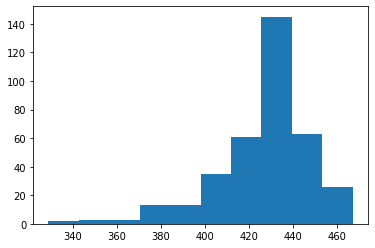

In [ ]:
plt.hist(neuron_list, 10)

To check if this is indp of being consecutive, just take random samples of neurons in 1st layer to knock out. And then take average (also look at distribution for more info). 

Take multiple random samples for each image.

In [ ]:
from random import sample

image_neuron_list = []
neuron_list = []
for img_ind in inds_0[0:100]:
    for i in range(3):
        num_w = 512
        while True:
            img_num_w_list = []
            weights_to_destroy = sample(list(range(512)), num_w)

            model_copy = copy.deepcopy(model)
            for ly in model_copy.named_modules():
                if ly[0] == 'fc1':
                    layer_0_to_1_weights = ly[1].weight.data
                    break
            for weight in weights_to_destroy:
                layer_0_to_1_weights[weight] = 0
            out = model_copy(train_data.__getitem__(img_ind)[0])
            if torch.argmax(out).item() == 0:
                # image_neuron_list.append((img_ind, num_w))
                img_num_w_list.append(num_w)
                break
            else:
                num_w -= 1
    avg_num_w = sum(img_num_w_list) / len(img_num_w_list)
    image_neuron_list.append((img_ind, avg_num_w))
    neuron_list.append(avg_num_w)

(array([ 1.,  2.,  6., 12., 12., 13., 16., 19., 15.,  4.]),
 array([432., 439., 446., 453., 460., 467., 474., 481., 488., 495., 502.]),
 <a list of 10 Patch objects>)

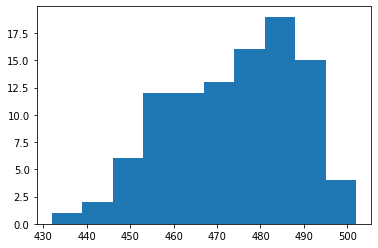

In [ ]:
plt.hist(neuron_list, 10)

Is it the number (b/c neurons add up to contribute), or certain neurons? Most likely, the number PLUS certain neurons?

Why those neurons? Do they play a role that can be described?

# Actv Max

https://github.com/christianversloot/machine-learning-articles/blob/main/visualizing-keras-model-inputs-with-activation-maximization.md

https://punndeeplearningblog.com/tutorial/visualizing-deep-learning/

https://morioh.com/p/f7a2bd9ff16c

In [ ]:
model

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)